epoch: 1 step: 375, loss is 2.322866916656494
epoch: 1 step: 750, loss is 1.045682668685913
epoch: 1 step: 1125, loss is 0.5016441345214844
epoch: 1 step: 1500, loss is 0.4597861170768738
epoch: 1 step: 1875, loss is 0.21280446648597717
epoch: 2 step: 375, loss is 0.06797132641077042
epoch: 2 step: 750, loss is 0.014705418609082699
epoch: 2 step: 1125, loss is 0.00738211115822196
epoch: 2 step: 1500, loss is 0.19618774950504303
epoch: 2 step: 1875, loss is 0.009098577313125134
epoch: 3 step: 375, loss is 0.06512992829084396
epoch: 3 step: 750, loss is 0.02589423768222332
epoch: 3 step: 1125, loss is 0.029618525877594948
epoch: 3 step: 1500, loss is 0.0075171710923314095
epoch: 3 step: 1875, loss is 0.00847355555742979
epoch: 4 step: 375, loss is 0.0029921773821115494
epoch: 4 step: 750, loss is 0.0012086965143680573
epoch: 4 step: 1125, loss is 0.09161122143268585
epoch: 4 step: 1500, loss is 0.023100266233086586
epoch: 4 step: 1875, loss is 0.006652528420090675
epoch: 5 step: 375, los

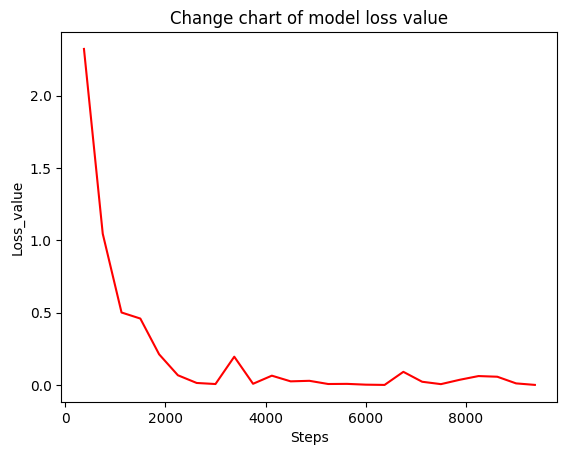

============== Starting Testing ==============
============== Accuracy:0.9879807692307693 ==============


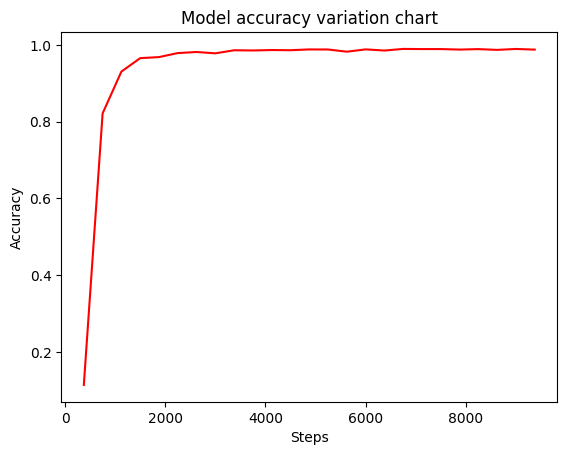

All the figures in this group are predicted correctly!
[1 6 4 5 8 1 6 0 5 1 1 7 7 7 2 6 9 6 1 6 8 7 4 1 9 4 6 0 1 4 4 2] <--Predicted figures
[1 6 4 5 8 1 6 0 5 1 1 7 7 7 2 6 9 6 1 6 8 7 4 1 9 4 6 0 1 4 4 2] <--The right numbers


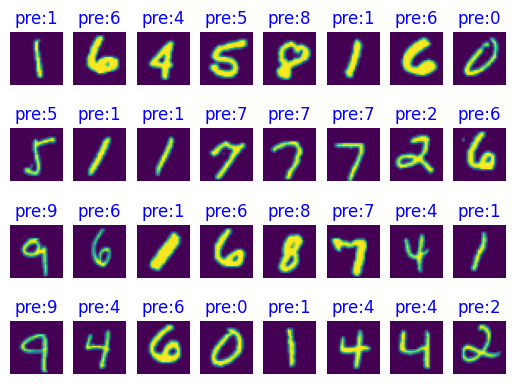

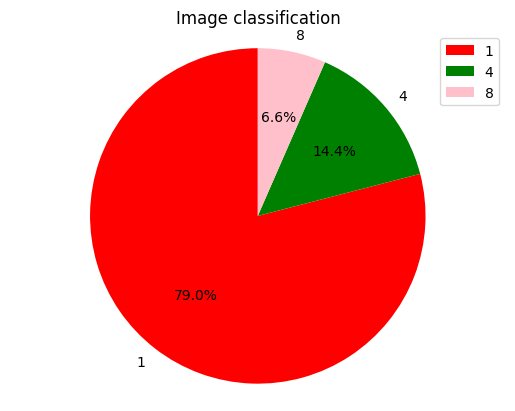

In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV
import mindspore.nn as nn
from mindspore import context, Tensor, Model, load_checkpoint, load_param_into_net
from mindspore import dtype as mstype
from mindspore.common.initializer import Normal
from mindspore.dataset.vision import Inter
from mindspore.nn import SoftmaxCrossEntropyWithLogits, Accuracy
from mindspore.train.callback import Callback, ModelCheckpoint, CheckpointConfig, LossMonitor

context.set_context(mode=context.GRAPH_MODE, device_target="GPU")


def create_dataset(data_path, batchSize, repeatSize=1, num_parallel_workers=1):
    """
    create dataset for train or test
    Args:
        data_path (str): Data path
        batchSize (int): The number of data records in each group
        repeatSize (int): The number of replicated data records
        num_parallel_workers (int): The number of parallel workers
    """
    # define dataset
    mnistDs = ds.MnistDataset(data_path)

    # define some parameters needed for data enhancement and rough justification
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0  # 归一化参数
    shift = 0.0
    rescale_nml = 1 / 0.3081  # 标准化参数
    shift_nml = -1 * 0.1307 / 0.3081

    # according to the parameters, generate the corresponding data enhancement method
    type_cast_op = C.TypeCast(mstype.int32)
    resize_op = CV.Resize((resize_height, resize_width), interpolation=Inter.LINEAR)  # 线性插值
    rescale_nml_op = CV.Rescale(rescale_nml, shift_nml)
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()

    # using map to apply operations to a dataset
    mnistDs = mnistDs.map(operations=type_cast_op, input_columns="label", num_parallel_workers=num_parallel_workers)
    mnistDs = mnistDs.map(operations=resize_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnistDs = mnistDs.map(operations=rescale_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnistDs = mnistDs.map(operations=rescale_nml_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnistDs = mnistDs.map(operations=hwc2chw_op, input_columns="image", num_parallel_workers=num_parallel_workers)

    # process the generated dataset
    buffer_size = 10000
    mnistDs = mnistDs.shuffle(buffer_size=buffer_size)
    mnistDs = mnistDs.batch(batchSize, drop_remainder=True)
    mnistDs = mnistDs.repeat(repeatSize)

    return mnistDs


class LeNet5(nn.Cell):
    """Lenet network structure."""

    # define the operator required
    def __init__(self, num_class=10, num_channel=1):  # 分类数: 10, 输入通道: 1
        super().__init__()
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')  # kernel_size = 5*5, output: 6*28*28
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')  # output = 16*10*10
        self.fc1 = nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)  # pool = 1/2
        self.flatten = nn.Flatten()

    # use the preceding operators to construct networks
    def construct(self, x):
        x = self.max_pool2d(self.relu(self.conv1(x)))
        x = self.max_pool2d(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# custom callback function
class StepLossAccInfo(Callback):  # 保存训练过程中的loss和accuracy
    def __init__(self, model_, evalDataset, stepsLoss, stepsEval):
        self.model = model_
        self.eval_dataset = evalDataset
        self.steps_loss = stepsLoss
        self.steps_eval = stepsEval

    def step_end(self, run_context):
        cb_params = run_context.original_args()
        cur_step = cb_params.cur_step_num
        if cur_step % 375 == 0:
            self.steps_loss["step"].append(cur_step)
            self.steps_loss["loss_value"].append(cb_params.net_outputs)
            acc = self.model.eval(self.eval_dataset, dataset_sink_mode=False)
            self.steps_eval["step"].append(cur_step)
            self.steps_eval["acc"].append(acc["Accuracy"])


lr = 0.01
momentum = 0.9

# create the network
network = LeNet5()

# define the optimizer
net_opt = nn.Momentum(network.trainable_params(), lr, momentum)

# define the loss function
net_loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

epoch_size = 5
mnist_path = "MNIST_Data"
batch_size = 32
repeat_size = 1
ds_train = create_dataset(os.path.join(mnist_path, "train"), batch_size)
eval_dataset = create_dataset(os.path.join(mnist_path, "test"), batch_size)

# define the model
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()})

# save the network model and parameters for subsequence fine-tuning
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=epoch_size)
# group layers into an object with training and evaluation features
ckpoint_cb = ModelCheckpoint(prefix="ReLu", config=config_ck)

steps_loss = {"step": [], "loss_value": []}  # 存放回调数据的字典
steps_eval = {"step": [], "acc": []}
# collect the steps,loss and accuracy information
step_loss_acc_info = StepLossAccInfo(model, eval_dataset, steps_loss, steps_eval)

model.train(epoch_size, ds_train, callbacks=[ckpoint_cb, LossMonitor(375), step_loss_acc_info], dataset_sink_mode=False)

steps = steps_loss["step"]
loss_value = steps_loss["loss_value"]
steps = list(map(int, steps))
loss_value = list(map(float, loss_value))
plt.plot(steps, loss_value, color="red")
plt.xlabel("Steps")
plt.ylabel("Loss_value")
plt.title("Change chart of model loss value")
plt.show()


# testing relate modules
def test_net(network_, model_, mnistPath):
    """Define the evaluation method."""
    print("============== Starting Testing ==============")
    # load the saved model for evaluation
    param_dict = load_checkpoint("ReLu-{}_1875.ckpt".format(str(epoch_size)))
    # load parameter to the network
    load_param_into_net(network_, param_dict)
    # load testing dataset
    ds_eval = create_dataset(os.path.join(mnistPath, "test"), batch_size)
    acc = model_.eval(ds_eval, dataset_sink_mode=False)
    print("============== Accuracy:{} ==============".format(acc['Accuracy']))


test_net(network, model, mnist_path)


def eval_show(stepsEval):
    plt.xlabel("Steps")
    plt.ylabel("Accuracy")
    plt.title("Model accuracy variation chart")
    plt.plot(stepsEval["step"], stepsEval["acc"], "red")
    plt.show()


eval_show(steps_eval)

ds_test = create_dataset(os.path.join(mnist_path, "test"), batch_size).create_dict_iterator()
data = next(ds_test)  # 取第一组测试数据
images = data["image"].asnumpy()  # 转换为numpy数据格式
labels = data["label"].asnumpy()

output = model.predict(Tensor(data['image']))
pred = np.argmax(output.asnumpy(), axis=1)  # 预测结果
flag = 1
for i in range(len(labels)):
    plt.subplot(4, 8, i + 1)
    color = 'blue' if pred[i] == labels[i] else 'red'
    plt.title("pre:{}".format(pred[i]), color=color)
    plt.imshow(np.squeeze(images[i].transpose(1, 2, 0)))
    plt.axis("off")
    if color == 'red':
        flag = 0
        print("Row {}, column {} is incorrectly identified as {}, the correct value should be {}".format(int(i / 8) + 1,
                                                                                                         i % 8 + 1,
                                                                                                         pred[i],
                                                                                                         labels[i]),
              '\n')
if flag:
    print("All the figures in this group are predicted correctly!")
print(pred, "<--Predicted figures")
print(labels, "<--The right numbers")
plt.show()

prb = output.asnumpy()


def plot_pie(prbs):
    dict1 = {}
    # remove the negative number and build the dictionary dict1. The key is the number and the value is the probability value
    for j in range(10):
        if prbs[j] > 0:
            dict1[str(j)] = prbs[j]

    label_list = dict1.keys()
    size = dict1.values()
    colors = ["red", "green", "pink", "blue", "purple", "orange", "gray"]
    color_ = colors[:len(size)]
    plt.pie(size, colors=color_, labels=label_list, labeldistance=1.1, autopct="%1.1f%%", shadow=False, startangle=90,
            pctdistance=0.6)
    plt.axis("equal")
    plt.legend()
    plt.title("Image classification")
    plt.show()


plot_pie(prb[0])


============== Starting Testing ==============
============== Accuracy:0.988 ==============
All the figures in this group are predicted correctly!
[2 8 8 1 3 7 2 6 8 7 1 0 7 7 3 5] <--Predicted figures
[2 8 8 1 3 7 2 6 8 7 1 0 7 7 3 5] <--The right numbers


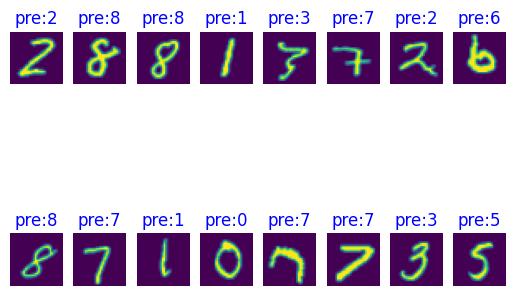

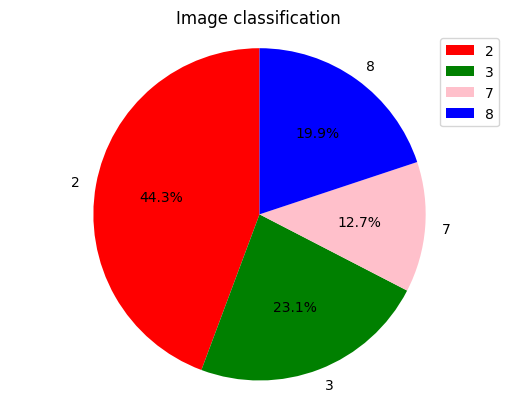

In [6]:
def create_img_dataset(data_path, batchSize=16, repeatSize=1, num_parallel_workers=1):
    """
    create dataset for test
    Args:
        data_path (str): Data path
        batchSize (int): The number of data records in each group
        repeatSize (int): The number of replicated data records
        num_parallel_workers (int): The number of parallel workers
    """
    # define dataset
    imgDs = ds.ImageFolderDataset(data_path, num_parallel_workers=num_parallel_workers, decode=True)  # 从树状结构的文件目录中读取图片构建源数据集

    # define some parameters needed for data enhancement and rough justification
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0  # 归一化参数
    shift = 0.0
    rescale_nml = 1 / 0.3081  # 标准化参数
    shift_nml = -1 * 0.1307 / 0.3081

    # according to the parameters, generate the corresponding data enhancement method
    type_cast_op = C.TypeCast(mstype.int32)
    resize_op = CV.Resize((resize_height, resize_width), interpolation=Inter.LINEAR)  # 线性插值
    rescale_nml_op = CV.Rescale(rescale_nml, shift_nml)
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()

    # using map to apply operations to a dataset
    imgDs = imgDs.map(operations=type_cast_op, input_columns="label", num_parallel_workers=num_parallel_workers)
    imgDs = imgDs.map(operations=resize_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    imgDs = imgDs.map(operations=rescale_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    imgDs = imgDs.map(operations=rescale_nml_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    imgDs = imgDs.map(operations=hwc2chw_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    imgDs = imgDs.map(operations=lambda x: x[:1], input_columns="image", num_parallel_workers=num_parallel_workers)  # 神来之笔, 降低通道数为 1

    # process the generated dataset
    buffer_size = 5000
    imgDs = imgDs.shuffle(buffer_size=buffer_size)
    imgDs = imgDs.batch(batchSize, drop_remainder=True)
    imgDs = imgDs.repeat(repeatSize)

    return imgDs


# testing relate modules
def test_img_net(network_, model_, imgPath):
    """Define the evaluation method."""
    print("============== Starting Testing ==============")
    # load the saved model for evaluation
    param_dict = load_checkpoint("ReLu-{}_1875.ckpt".format(str(epoch_size)))
    # load parameter to the network
    load_param_into_net(network_, param_dict)
    # load testing dataset
    ds_eval = create_img_dataset(os.path.join(imgPath, "test"))
    acc = model_.eval(ds_eval, dataset_sink_mode=False)
    print("============== Accuracy:{} ==============".format(acc['Accuracy']))


img_path = 'Image_Data'
test_img_net(network, model, img_path)


ds_test = create_img_dataset(os.path.join(img_path, "test")).create_dict_iterator()
data = next(ds_test)  # 取第一组测试数据
images = data["image"].asnumpy()  # 转换为numpy数据格式
labels = data["label"].asnumpy()

output = model.predict(Tensor(data['image']))
pred = np.argmax(output.asnumpy(), axis=1)  # 预测结果
flag = 1
for i in range(len(labels)):
    plt.subplot(2, 8, i + 1)
    color = 'blue' if pred[i] == labels[i] else 'red'
    plt.title("pre:{}".format(pred[i]), color=color)
    plt.imshow(np.squeeze(images[i]))
    plt.axis("off")
    if color == 'red':
        flag = 0
        print("Row {}, column {} is incorrectly identified as {}, the correct value should be {}".format(int(i / 8) + 1,
                                                                                                         i % 8 + 1,
                                                                                                         pred[i],
                                                                                                         labels[i]),
              '\n')
if flag:
    print("All the figures in this group are predicted correctly!")
print(pred, "<--Predicted figures")
print(labels, "<--The right numbers")
plt.show()

prb = output.asnumpy()


def plot_pie(prbs):
    dict1 = {}
    # remove the negative number and build the dictionary dict1. The key is the number and the value is the probability value
    for j in range(10):
        if prbs[j] > 0:
            dict1[str(j)] = prbs[j]

    label_list = dict1.keys()
    size = dict1.values()
    colors = ["red", "green", "pink", "blue", "purple", "orange", "gray"]
    color_ = colors[:len(size)]
    plt.pie(size, colors=color_, labels=label_list, labeldistance=1.1, autopct="%1.1f%%", shadow=False, startangle=90,
            pctdistance=0.6)
    plt.axis("equal")
    plt.legend()
    plt.title("Image classification")
    plt.show()


plot_pie(prb[0])


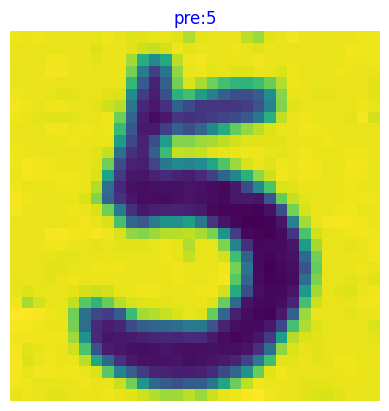

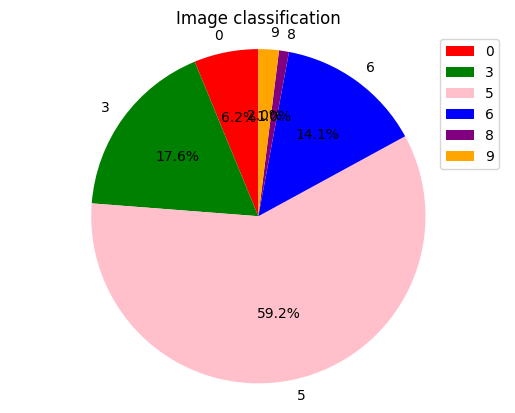

In [7]:
def create_img_dataset1(data_path, batchSize=1, repeatSize=1, num_parallel_workers=1):
    """
    create dataset for test
    Args:
        data_path (str): Data path
        batchSize (int): The number of data records in each group
        repeatSize (int): The number of replicated data records
        num_parallel_workers (int): The number of parallel workers
    """
    # define dataset
    imgDs = ds.ImageFolderDataset(data_path, num_parallel_workers=num_parallel_workers, decode=True)  # 从树状结构的文件目录中读取图片构建源数据集

    # define some parameters needed for data enhancement and rough justification
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0  # 归一化参数
    shift = 0.0
    rescale_nml = 1 / 0.3081  # 标准化参数
    shift_nml = -1 * 0.1307 / 0.3081

    # according to the parameters, generate the corresponding data enhancement method
    type_cast_op = C.TypeCast(mstype.int32)
    resize_op = CV.Resize((resize_height, resize_width), interpolation=Inter.LINEAR)  # 线性插值
    rescale_nml_op = CV.Rescale(rescale_nml, shift_nml)
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()

    # using map to apply operations to a dataset
    imgDs = imgDs.map(operations=type_cast_op, input_columns="label", num_parallel_workers=num_parallel_workers)
    imgDs = imgDs.map(operations=resize_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    imgDs = imgDs.map(operations=rescale_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    imgDs = imgDs.map(operations=rescale_nml_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    imgDs = imgDs.map(operations=hwc2chw_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    imgDs = imgDs.map(operations=lambda x: x[:1], input_columns="image", num_parallel_workers=num_parallel_workers)  # 神来之笔, 降低通道数为 1

    # process the generated dataset
    imgDs = imgDs.batch(batchSize, drop_remainder=True)
    imgDs = imgDs.repeat(repeatSize)

    return imgDs


ds_test = create_img_dataset1('final_test').create_dict_iterator()
data = next(ds_test)  # 取第一组测试数据
images = data["image"].asnumpy()  # 转换为numpy数据格式
output = model.predict(Tensor(data['image']))
pred = np.argmax(output.asnumpy(), axis=1)  # 预测结果
color = 'blue' if pred[0] == 5 else 'red'
plt.title("pre:{}".format(pred[0]), color=color)
plt.imshow(np.squeeze(images[0]))
plt.axis("off")
plt.show()

prb = output.asnumpy()


def plot_pie(prbs):
    dict1 = {}
    # remove the negative number and build the dictionary dict1. The key is the number and the value is the probability value
    for j in range(10):
        if prbs[j] > 0:
            dict1[str(j)] = prbs[j]

    label_list = dict1.keys()
    size = dict1.values()
    colors = ["red", "green", "pink", "blue", "purple", "orange", "gray"]
    color_ = colors[:len(size)]
    plt.pie(size, colors=color_, labels=label_list, labeldistance=1.1, autopct="%1.1f%%", shadow=False, startangle=90,
            pctdistance=0.6)
    plt.axis("equal")
    plt.legend()
    plt.title("Image classification")
    plt.show()


plot_pie(prb[0])